In [1]:
import numpy as np
def conv3DnpTest(a,k):
    a=np.asarray(a,dtype=np.float64)
    k=np.asarray(k,dtype=np.float64)
    a_pad=np.pad(a,[(0, len(k)-1), (0, len(k[0])-1),(0, 0)], mode='constant', constant_values=0) #required padding
    k_pad=np.pad(k,[(0, len(a)-1), (0, len(a[0])-1),(0, 0)], mode='constant', constant_values=0)
    A=np.fft.fftn(a_pad) 
    K=np.fft.fftn(k_pad) 
    C=A*K
    c=np.fft.ifftn(C)
    c=c[int(len(k)/2):int(len(k)/2)+len(a),int(len(k[0])/2):int(len(k[0])/2)+len(a[0]),:] #'same' mode for x and y, 'full' mode for z
    return c
def convertTo3D(a):
    m=len(a)
    n=len(a[0])
    a=np.asarray(a,dtype=np.int16)
    A=np.zeros((m,n,512),dtype=np.float64) #512=255*2+1
    for x in range(m):
        for y in range(n):
            if a[x][y]>=0:
                A[x][y][a[x][y]]=1
    return A
def convertTo2D(A):
    a=np.zeros((len(A),len(A[0])),dtype=np.float64)
    for x in range(len(A)):
        for y in range(len(A[0])):
            for z in reversed(range(512)):
                if np.rint(A[x][y][z])>=1:
                    a[x][y]=z
                    break
    return a
def fastDialConvNPUmbra(a,k):
    #m=int(2*log(len(k))+2) #large enough for filter, larger values cause overflow
    a=np.asarray(a,dtype=np.int16)
    k=np.asarray(k,dtype=np.int16)
    A=convertTo3D(a)
    K=convertTo3D(k)
    C=conv3DnpTest(A,K)
    c=convertTo2D(C)
    #c=np.where(c==np.nan,128,c)
    c=np.where(c>255,255,c)
    #c=np.where(c<0,0,c)
    c=np.array(c,dtype=np.uint8)
    return c

In [2]:
from numba import njit
@njit
def njit_convertTo3D(a,A):
    for x in range(len(a)):
        for y in range(len(a[0])):
            if a[x][y]>=0:
                A[x][y][a[x][y]]=1
@njit
def njit_convertTo2D(A,a):
    for x in range(len(A)):
        for y in range(len(A[0])):
            for z in range(511,-1,-1):
                if np.rint(A[x][y][z])>=1:
                    a[x][y]=z
                    break
def njit_fastDialConvNPUmbra(a,k):
    #m=int(2*log(len(k))+2) #large enough for filter, larger values cause overflow
    a=np.asarray(a,dtype=np.int16)
    k=np.asarray(k,dtype=np.int16)
    A=np.zeros((len(a),len(a[0]),512),dtype=np.int16)
    njit_convertTo3D(a,A)
    K=np.zeros((len(k),len(k[0]),512),dtype=np.int16)
    njit_convertTo3D(k,K)
    C=conv3DnpTest(A,K)
    C=np.rint(C)
    C=np.asarray(C,dtype=np.int32)
    c=np.zeros((len(a),len(a[0])),dtype=np.int32)
    njit_convertTo2D(C,c)
    #c=np.where(c==np.nan,128,c)
    c=np.where(c>255,255,c)
    #c=np.where(c<0,0,c)
    c=np.array(c,dtype=np.uint8)
    return c

fastDialConvNPUmbra(a,k) is dilation of 8-bit image a, with non-flat(8-bit) filter k using exact FFT method [1].

njit_fastDialConvNPUmbra(a,k) is the Numba version (just in time compilation) of fastDialConvNPUmbra(a,k). njit_fastDialConvNPUmbra() is faster and usually used in the experiments. 

[1]: Sridhar, Vivek, and Michael Breuß. "An Exact Fast Fourier Method for Morphological Dilation and Erosion Using the Umbra Technique." In 2022 19th Conference on Robots and Vision (CRV), pp. 190-196. IEEE, 2022.

In [3]:
def fastDial(a,k):
    #m=int(2*log(len(k))+2) #large enough for filter, larger values cause overflow
    a=np.array(a,dtype=np.float)
    k=np.array(k,dtype=np.float)
    m=0.16 #both for k1 and b2
    ma=m*a
    exp_ma=np.exp(ma)
    mk=m*k
    exp_mk=np.exp(mk)
    exp_mc=Sig.convolve(exp_ma, exp_mk, mode='same',method='fft') #probem lies in this step if fft used
    mc=np.log(exp_mc)
    c=mc/m
    c=np.where(c==np.nan,128,c)
    c=np.where(c>255,255,c)
    c=np.where(c<0,0,c)
    c=np.array(c,dtype=np.uint8)
    return c
@njit
def dial(a, k):
    m = int((len(k)+1)/2)
    a=np.asarray(a,dtype=np.uint16)
    c=np.zeros_like(a,dtype=np.uint16)
    for xa in range(len(a)):
        for ya in range(len(a[0])):
            for xk in range(m):
                for yk in range(m):
                    if((xa-xk) >= 0):
                        if((ya-yk) >= 0):
                            if(k[m-xk-1][m-yk-1] >= 0):
                                c[xa-xk][ya-yk] = max(a[xa-xk][ya-yk], a[xa][ya]+k[m-xk-1][m-yk-1], c[xa-xk][ya-yk])
                                c[xa-xk][ya-yk] = min(255, c[xa-xk][ya-yk])
                            # print (xa-xk)
                            # print (ya-yk)
                            # print c
                        if((ya+yk) < len(a[0])):
                            if(k[m-xk-1][m+yk-1] >= 0):
                                c[xa-xk][ya+yk] = max(a[xa-xk][ya+yk], a[xa][ya]+k[m-xk-1][m+yk-1], c[xa-xk][ya+yk])
                                c[xa-xk][ya+yk] = min(255, c[xa-xk][ya+yk])
                            # print (xa-xk)
                            # print (ya+yk)
                            # print c
                    if((xa+xk) < len(a)):
                        if((ya-yk) >= 0):
                            if(k[m+xk-1][m-yk-1] >= 0):
                                c[xa+xk][ya-yk] = max(a[xa+xk][ya-yk], a[xa][ya]+k[m+xk-1][m-yk-1], c[xa+xk][ya-yk])
                                c[xa+xk][ya-yk] = min(255, c[xa+xk][ya-yk])
                            # print (xa+xk)
                            # print (ya-yk)
                            # print c
                        if((ya+yk) < len(a[0])):
                            if(k[m+xk-1][m+yk-1] >= 0):
                                c[xa+xk][ya+yk] = max(a[xa+xk][ya+yk], a[xa][ya]+k[m+xk-1][m+yk-1], c[xa+xk][ya+yk])
                                c[xa+xk][ya+yk] = min(c[xa+xk][ya+yk], 255)
                            # print (xa+xk)
                            # print (ya+yk)
                            # print c
    c=np.asarray(c, dtype=np.uint8)
    return c

  fastDial(a,k) and dial(a,k) are also defined here in 8-bit setting. 
  
  fastDial is the fast approximation defined in [2].
  
  dial() is the classical dilation [3], wheere the dilated image is computed by placing the filter over each pixel of the image and doing the computation for each pair of overlayed pixels in image and filter.
  
  [2]: Kahra, Marvin, Vivek Sridhar, and Michael Breuß. "Fast morphological dilation and erosion for grey scale images using the Fourier transform." In International Conference on Scale Space and Variational Methods in Computer Vision, pp. 65-77. Springer, Cham, 2021.
  
  [3]: Haralick, Robert M., Stanley R. Sternberg, and Xinhua Zhuang. "Image analysis using mathematical morphology." IEEE transactions on pattern analysis and machine intelligence 4 (1987): 532-550.

In [4]:
#random image can be generated using 
img=np.random.randint(0,255,size=(99, 99)) #size is 99 *99, any other size can be chosen

In [5]:
#random non-flat filter can be generated as
filt=np.random.randint(0,25,size=(5, 5)) 
#here, the value at each pixel of the filter is between 0 and 25 (upper limit could be 255, for 8-bit setting)
#here, the filter is of shape 5*5

In [11]:
#Now, we generate a filter whose domain is not a regular shape(like square, rectangle etc.) and might have random gaps
#We have used the filter generated by the follwing code, in [1], to demonstrate that the proposed method gives 
# perfect results, even when the filter is non-flat and has irrefular shape. 
diamondNF=[]
for i in range(21):
    b=[]
    for j in range(21):
        b.append(-256)
        if(i==10):
            b[j]=0
        if((i<10)and(j<=(10+i))and(j>=(10-i))):
            b[j]=(i*j)%15
        if((i>10)and(j>=(i-10))and(j<=(30-i))):
            b[j]=-256*np.random.randint(0,2)
    diamondNF.append(b)
print(diamondNF)
#Note here, in [1] negative value for pixel represents that the pixel is not in the domain of filter/image. 
#in [2], this is done by the value -256, for 8-bit setting and by -infinity in [3].

[[-256, -256, -256, -256, -256, -256, -256, -256, -256, -256, 0, -256, -256, -256, -256, -256, -256, -256, -256, -256, -256], [-256, -256, -256, -256, -256, -256, -256, -256, -256, 9, 10, 11, -256, -256, -256, -256, -256, -256, -256, -256, -256], [-256, -256, -256, -256, -256, -256, -256, -256, 1, 3, 5, 7, 9, -256, -256, -256, -256, -256, -256, -256, -256], [-256, -256, -256, -256, -256, -256, -256, 6, 9, 12, 0, 3, 6, 9, -256, -256, -256, -256, -256, -256, -256], [-256, -256, -256, -256, -256, -256, 9, 13, 2, 6, 10, 14, 3, 7, 11, -256, -256, -256, -256, -256, -256], [-256, -256, -256, -256, -256, 10, 0, 5, 10, 0, 5, 10, 0, 5, 10, 0, -256, -256, -256, -256, -256], [-256, -256, -256, -256, 9, 0, 6, 12, 3, 9, 0, 6, 12, 3, 9, 0, 6, -256, -256, -256, -256], [-256, -256, -256, 6, 13, 5, 12, 4, 11, 3, 10, 2, 9, 1, 8, 0, 7, 14, -256, -256, -256], [-256, -256, 1, 9, 2, 10, 3, 11, 4, 12, 5, 13, 6, 14, 7, 0, 8, 1, 9, -256, -256], [-256, 9, 3, 12, 6, 0, 9, 3, 12, 6, 0, 9, 3, 12, 6, 0, 9, 3, 12, 6,

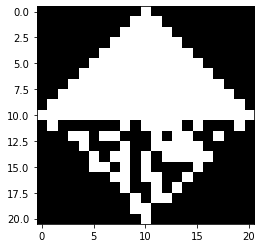

In [12]:
from matplotlib import pyplot as plt
diamondNF=np.asarray(diamondNF,dtype=np.int32)
def footprint(k):
    a=np.where(k>=0,1,0)
    return a
diamondNF_fp=footprint(diamondNF)
plt.imshow(diamondNF_fp, cmap='gray', vmin=0, vmax=1)
plt.savefig('diamondNF_fp.png',bbox_inches='tight')
plt.show()

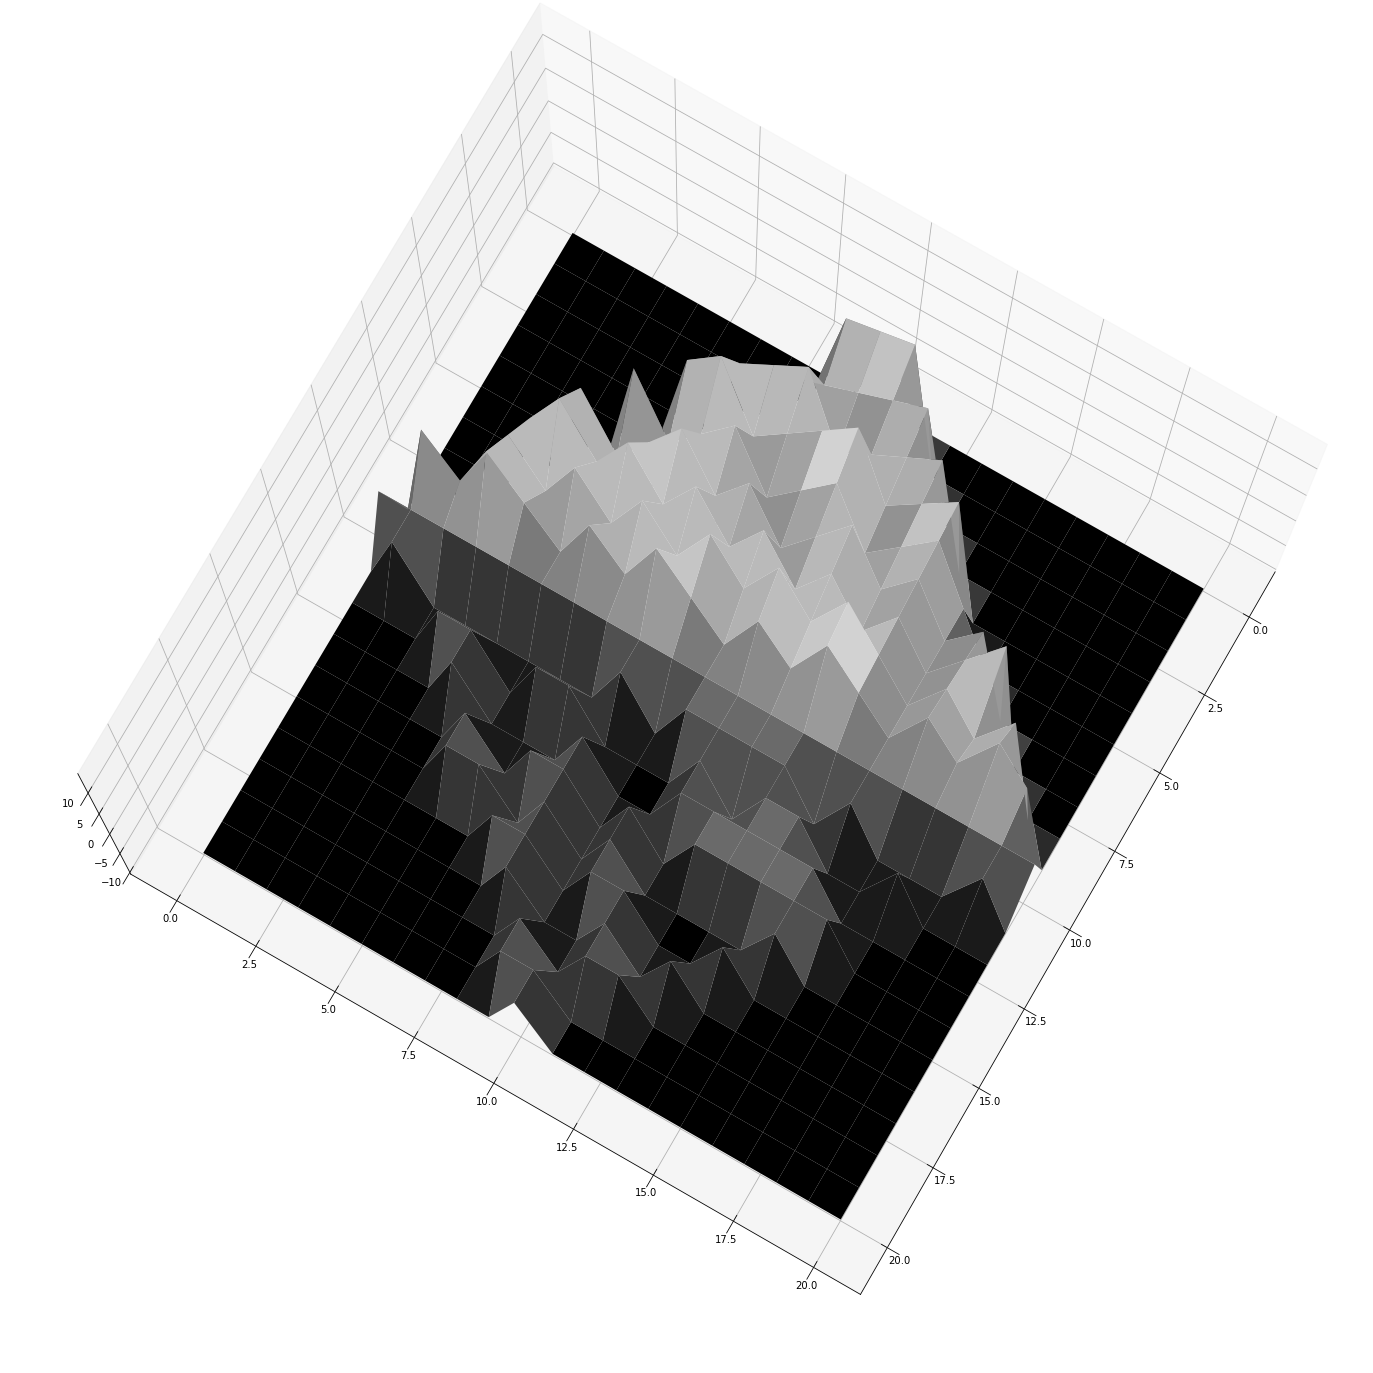

In [13]:
import importlib
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
img_gray=np.where(diamondNF>=0,diamondNF,-10)
xx, yy = np.mgrid[0:img_gray.shape[0], 0:img_gray.shape[1]]
fig = plt.figure(figsize=(25, 25))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, img_gray, rstride=1, cstride=1,
                cmap=plt.cm.gray, linewidth=2,vmin=-10,vmax=14)
ax.view_init(80, 30)
plt.savefig('diamondNF_Umbra.png',bbox_inches='tight')
plt.show()